In [1]:
%pylab inline
from constant import * 

Populating the interactive namespace from numpy and matplotlib


In [2]:
Vgrid = np.load("Value00.npy")

Probability of transition between employment and unemployment states is know: $P(0, 1 | S)$, $P(1, 0 | S)$, $P(1, 1 | S)$, $P(0, 0 | S)$   
   
   
The unconditional probability is:    
$$P(0,1) = \Sigma_{s = 1}^{s = 8}P(0, 1 | S = s)P(S=s)$$

In [3]:
S_distribution = jnp.ones(nS)/nS
for i in range(100):
    S_distribution = jnp.matmul(S_distribution, Ps)
S_distribution

DeviceArray([0.08723426, 0.12654275, 0.11381963, 0.17240335, 0.17240335,
             0.11381961, 0.12654276, 0.08723425], dtype=float32)

In [4]:
#P(0,1)
P01 = jnp.dot(Pe[:,0],S_distribution)
#P(1,0)
P10 = jnp.dot(Pe[:,1],S_distribution)
jnp.array([[1-P01, P01],[P10, 1-P10]])

DeviceArray([[0.23330271, 0.7666973 ],
             [0.06959809, 0.9304019 ]], dtype=float32)

In [5]:
E_distribution = jnp.ones(2)/2
for i in range(100):
    E_distribution = jnp.matmul(E_distribution, jnp.array([[1-P01, P01],[P10, 1-P10]]))
E_distribution

DeviceArray([0.08322192, 0.91677827], dtype=float32)

In [6]:
num = 10000
'''
    x = [w,n,m,s,e,o]
    x = [5,0,0,0,0,0]
'''
from jax import random

def simulation(key):
    initE = random.choice(a = nE, p=E_distribution, key = key)
    initS = random.choice(a = nS, p=S_distribution, key = key)
    x = [5, 0, 0, initS, initE, 0]
    path = []
    move = []
    for t in range(T_min, T_max-1):
        _, key = random.split(key)
        _,a = V(t,Vgrid[:,:,:,:,:,:,t+1],x)
        xp = transition(t,a.reshape((1,-1)),x)
        p = xp[:,-1]
        x_next = xp[:,:-1]
        path.append(x)
        move.append(a)
        x = x_next[random.choice(a = nS*nE, p=p, key = key)]
    return jnp.array(path), jnp.array(move)

In [7]:
%%time
# simulation part 
keys = vmap(random.PRNGKey)(jnp.arange(num))
Paths, Moves = vmap(simulation)(keys)

CPU times: user 4h 29min 25s, sys: 24min 46s, total: 4h 54min 12s
Wall time: 13min 13s


In [8]:
# x = [w,n,m,s,e,o]
# x = [0,1,2,3,4,5]
ws = Paths[:,:,0].T
ns = Paths[:,:,1].T
ms = Paths[:,:,2].T
ss = Paths[:,:,3].T
es = Paths[:,:,4].T
os = Paths[:,:,5].T
cs = Moves[:,:,0].T
bs = Moves[:,:,1].T
ks = Moves[:,:,2].T
hs = Moves[:,:,3].T
actions = Moves[:,:,4].T

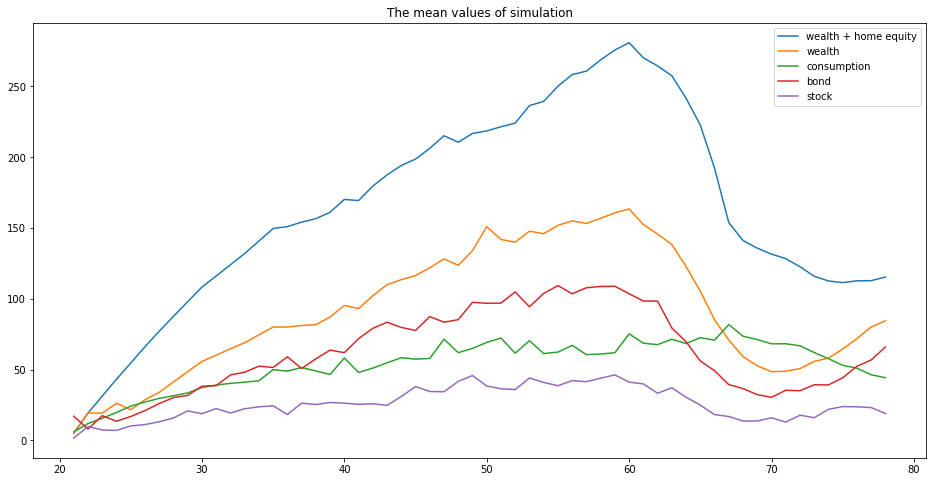

In [9]:
plt.figure(figsize = [16,8])
plt.title("The mean values of simulation")
plt.plot(range(21, T_max-1 + 20),jnp.mean(ws + H*pt*os - ms,axis = 1)[:-1], label = "wealth + home equity")
plt.plot(range(21, T_max-1 + 20),jnp.mean(ws,axis = 1)[:-1], label = "wealth")
plt.plot(range(21, T_max-1 + 20),jnp.mean(cs,axis = 1)[:-1], label = "consumption")
plt.plot(range(21, T_max-1 + 20),jnp.mean(bs,axis = 1)[:-1], label = "bond")
plt.plot(range(21, T_max-1 + 20),jnp.mean(ks,axis = 1)[:-1], label = "stock")
# plt.plot((hs*pr).mean(axis = 1)[:-1], label = "housing")
plt.legend()

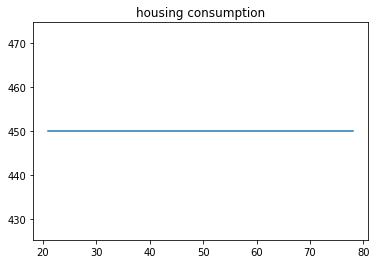

In [10]:
plt.title("housing consumption")
plt.plot(range(21, T_max-1 + 20),(hs).mean(axis = 1)[:-1], label = "housing")

In [11]:
(os).mean(axis = 1)[:-1]

DeviceArray([0.    , 0.    , 0.3249, 0.4398, 0.8386, 0.8997, 0.9859,
             0.9932, 0.9963, 0.997 , 0.9986, 0.9993, 0.9992, 0.9921,
             0.9871, 0.9546, 0.9418, 0.9295, 0.8881, 0.883 , 0.8769,
             0.8632, 0.8548, 0.8787, 0.8844, 0.8884, 0.8887, 0.891 ,
             0.8628, 0.7757, 1.    , 0.9996, 0.9991, 0.9983, 0.9967,
             0.995 , 0.9932, 0.991 , 0.9878, 0.9814, 0.9652, 0.9503,
             0.9301, 0.9047, 0.8731, 0.7971, 0.6351, 0.6093, 0.5936,
             0.57  , 0.5251, 0.4646, 0.3797, 0.3337, 0.2764, 0.2301,
             0.1807, 0.1648], dtype=float32)

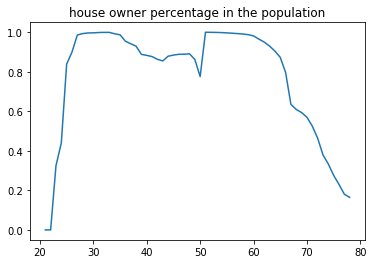

In [12]:
plt.title("house owner percentage in the population")
plt.plot(range(21, T_max-1 + 20),(os).mean(axis = 1)[:-1], label = "owning")

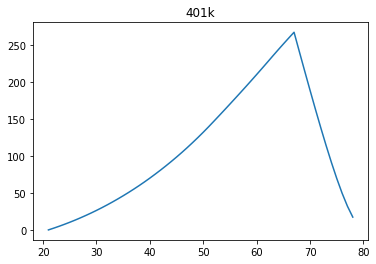

In [13]:
plt.title("401k")
plt.plot(range(21, T_max-1 + 20),(ns).mean(axis = 1)[:-1], label = "housing")

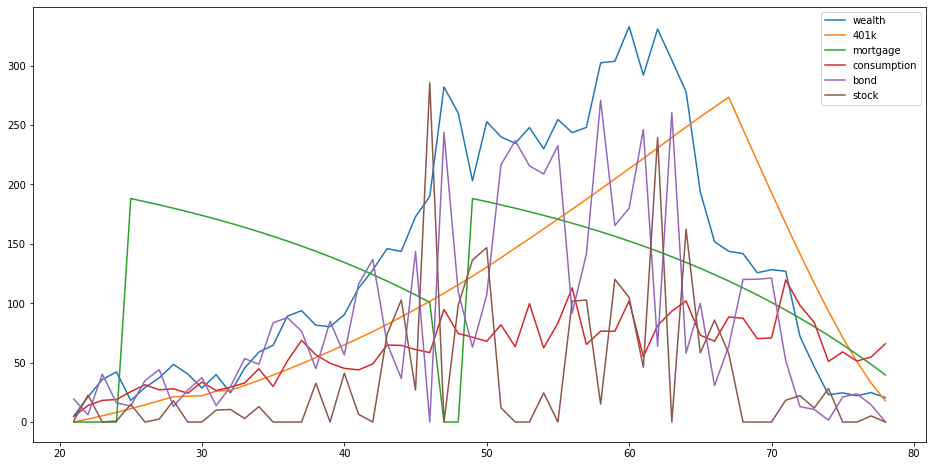

In [58]:
# agent number, x = [w,n,m,s,e,o]
agentNum = 10
plt.figure(figsize = [16,8])
plt.plot(range(21, T_max-1 + 20),ws[:,agentNum][:-1], label = "wealth")
plt.plot(range(21, T_max-1 + 20),ns[:,agentNum][:-1], label = "401k")
plt.plot(range(21, T_max-1 + 20),ms[:,agentNum][:-1], label = "mortgage")
plt.plot(range(21, T_max-1 + 20),cs[:,agentNum][:-1], label = "consumption")
plt.plot(range(21, T_max-1 + 20),bs[:,agentNum][:-1], label = "bond")
plt.plot(range(21, T_max-1 + 20),ks[:,agentNum][:-1], label = "stock")
plt.legend()

In [63]:
m

DeviceArray(11.050476, dtype=float32)

In [62]:
ms[:,agentNum][:-1]

DeviceArray([  0.      ,   0.      ,   0.      ,   0.      , 188.09999 ,
             185.514   , 182.81166 , 179.9877  , 177.03667 , 173.95284 ,
             170.73022 , 167.3626  , 163.84343 , 160.1659  , 156.32288 ,
             152.30692 , 148.11024 , 143.72472 , 139.14185 , 134.35275 ,
             129.34814 , 124.11833 , 118.653175, 112.942085, 106.974   ,
             100.73735 ,   0.      ,   0.      , 188.09999 , 185.514   ,
             182.81166 , 179.9877  , 177.03667 , 173.95284 , 170.73022 ,
             167.3626  , 163.84343 , 160.1659  , 156.32288 , 152.30692 ,
             148.11024 , 143.72472 , 139.14185 , 134.35275 , 129.34814 ,
             124.11833 , 118.653175, 112.942085, 106.974   , 100.73735 ,
              94.220055,  87.40948 ,  80.29243 ,  72.85511 ,  65.083115,
              56.961376,  48.47416 ,  39.60502 ], dtype=float32)

In [84]:
ms[:,agentNum][28]

DeviceArray(188.09999, dtype=float32)

In [85]:
ms[:,agentNum][58]

DeviceArray(30.336767, dtype=float32)

In [95]:
M = H*pt*0.8
M*(1+rh)

188.1

In [96]:
for i in range(30):
    print(i+28,":", M*(1+rh))
    M = M*(1+rh) - m
print(M)

28 : 188.1
29 : 185.01675
30 : 181.79475
31 : 178.42776
32 : 174.90926
33 : 171.23242
34 : 167.39012
35 : 163.37492
36 : 159.17905
37 : 154.79436
38 : 150.21236
39 : 145.42416
40 : 140.4205
41 : 135.19167
42 : 129.72754
43 : 124.017525
44 : 118.05056
45 : 111.81509
46 : 105.29901
47 : 98.489716
48 : 91.374
49 : 83.93808
50 : 76.16754
51 : 68.04733
52 : 59.561714
53 : 50.69424
54 : 41.42773
55 : 31.74423
56 : 21.624971
57 : 11.050347
-0.00012874603


In [60]:
os[:,agentNum][:-1][26]

DeviceArray(0., dtype=float32)

In [37]:
ks[:,agentNum][:-1][27]

DeviceArray(165.07613, dtype=float32)

In [38]:
bs[:,agentNum][:-1][27]

DeviceArray(30.982756, dtype=float32)

In [39]:
ks[:,agentNum][:-1][28]

DeviceArray(11.813882, dtype=float32)

In [40]:
bs[:,agentNum][:-1][28]

DeviceArray(212.86275, dtype=float32)

In [45]:
r_k[jnp.array(ss[:,agentNum][:-1][28], dtype = int8)]

DeviceArray(0.2114884, dtype=float32)

In [44]:
r_b[jnp.array(ss[:,agentNum][:-1][27], dtype = int8)]

DeviceArray(0.01124221, dtype=float32)

In [46]:
r_k

DeviceArray([-0.2770296 , -0.10135021, -0.18776457, -0.01208517,
              0.2114884 ,  0.3871678 ,  0.30075344,  0.47643283],            dtype=float32)

In [25]:
H 

450

In [20]:
H*pt*0.8

180.0

In [22]:
m

DeviceArray(11.050476, dtype=float32)

In [24]:
pr*450

18.0

In [26]:
c_s

25

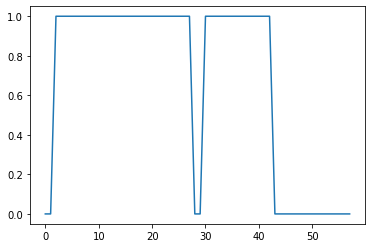

In [19]:
plt.plot(os[:,agentNum][:-1])

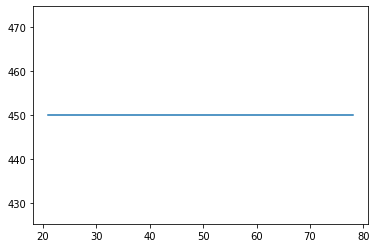

In [16]:
plt.plot(range(21, T_max-1 + 20),hs[:,agentNum][:-1], label = "stock")